In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv("data/Hobart_airport_daily_precip.csv")
dates = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [3]:
# Clean up data frame
df = df.drop('Product code', 1)
df = df.drop('Bureau of Meteorology station number', 1)
df = df.rename(columns={'Rainfall amount (millimetres)': 'PPT', 'Period over which rainfall was measured (days)': 'period'})

In [4]:
# Make an Australian year, drop first and last six months.
dates = dates + pd.DateOffset(months=-6)
df['dates'] = dates
df = df.set_index('dates')
df.Year = df.index.year
df.Month = df.index.month
first_year = df.index.year[0]
last_year = df.index.year[-1]
df = df[df.Year > first_year]
df = df[df.Year < last_year]

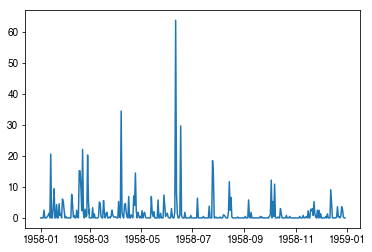

In [54]:
# Plot "new" 1958, this should shift PPT to "UK" summer
plt.plot(df[df.Year==1958].PPT)

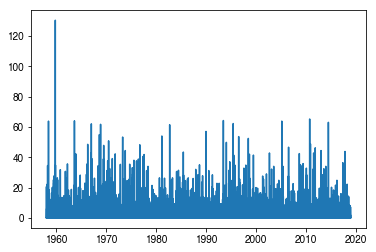

In [6]:
# Plot all years
plt.plot(df.PPT)

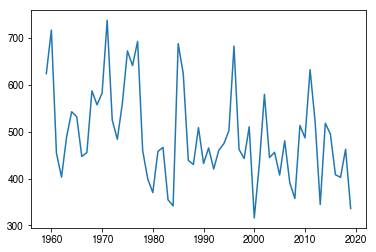

In [55]:
# Plot MAP
dfa = df.resample('A').agg("sum")
plt.plot(dfa.PPT)

In [56]:
print("MAP (mm yr-1):", dfa.PPT.mean())

MAP (mm yr-1): 492.8950819672132


In [57]:
# Calculate consecutive dry days
consecutive_dry = [ 1 if i == 0.0 else 0 for i in df.PPT]
for i in range(1, len(consecutive_dry)):
    if consecutive_dry[i] == 1:
        consecutive_dry[i] += consecutive_dry[i-1]

In [58]:
# Calculate consecutive wet days
consecutive_wet = [1 if i > 0.0 else 0 for i in df.PPT]
for i in range(1, len(consecutive_wet)):
    if consecutive_wet[i] == 1:
        consecutive_wet[i] += consecutive_wet[i-1]

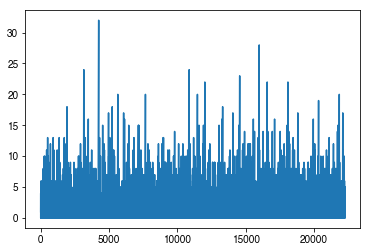

In [41]:
plt.plot(consecutive_dry)

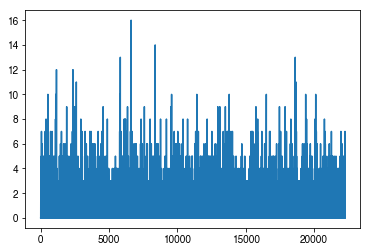

In [43]:
plt.plot(consecutive_wet)

In [46]:
df_spells = pd.DataFrame(consecutive_wet, columns=['wet'])
df_spells["dry"] = consecutive_dry
df_spells['dates'] = df.index
df_spells = df_spells.set_index('dates')

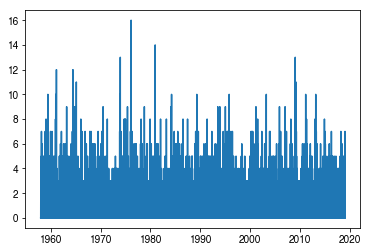

In [47]:
plt.plot(df_spells.wet)

In [59]:
df_spells_a = df_spells.resample('A').agg("max")

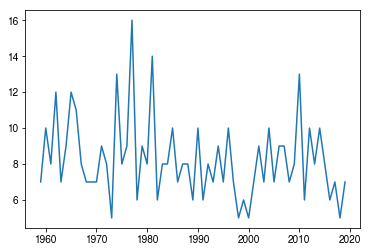

In [60]:
plt.plot(df_spells_a.wet)

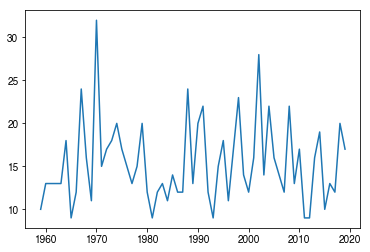

In [61]:
plt.plot(df_spells_a.dry)

In [62]:
print(df_spells_a.dry.mean())

15.37704918032787


14.098360655737705


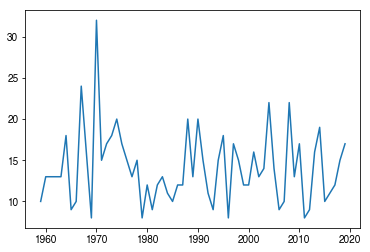

In [67]:
# Do same thing for spring/summer - MAX
df_spells_grw = df_spells[(df_spells.index.month >= 4) & (df_spells.index.month < 10)]
df_spells_grw_a = df_spells_grw.resample('A').agg("max")
plt.plot(df_spells_grw_a.dry)
print(df_spells_grw_a.dry.mean())

2.3302004364890685


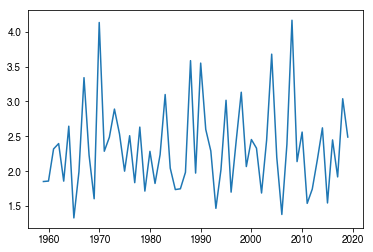

In [74]:
# Do same thing for spring/summer - MEAN
df_spells_grw = df_spells[(df_spells.index.month >= 4) & (df_spells.index.month < 10)]
df_spells_grw_a = df_spells_grw.resample('A').agg("mean")
plt.plot(df_spells_grw_a.dry)
print(df_spells_grw_a.dry.mean())

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


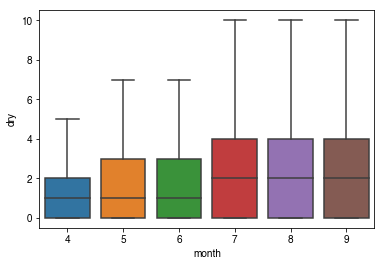

In [78]:
df_spells_grw["month"] = df_spells_grw.index.month

import seaborn as sns

sns.boxplot(data=df_spells_grw, x='month', y="dry", showfliers=False) # ignoring outliers for visual purposes
plt.show()